# Electrophysiology Experiment Simulator
This notebook will let you scrub through an experiment data displaying electrophysiology data, visualize it on a 3D model of the brain, and try various electrode insertions on the data. Since there are so many functions, we highly reccomemd running steps through 1, and then hitting run all and scrolling directly to the bottom!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/electrophysiology-experiment-simulator/blob/main/src/electrophysiology_experiment_simulator/pinpoint_interactive_graphs_demo.ipynb)

## 0. Setting up the python environment

First, we need to install the necessary packages. This step will have to be run anytime you are running the notebook for the first time in its current environment.

In [ ]:
! pip install ipympl > /dev/null 2>&1
! pip install oursin==0.5.3 > /dev/null 2>&1

In [ ]:
import oursin as urchin
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
import pandas as pd
import json
import os

urchin.setup(standalone=True)
%matplotlib widget

# To enable use on colab:
from google.colab import output
output.enable_custom_widget_manager()

(URN) connected to server
Login sent with ID: cf0868ac, copy this ID into the renderer to connect.


# 0.5 Setting up pinpoint

### Visit https://data.virtualbrainlab.org/Pinpoint/.

Follow the steps below to prepare it to run with out code:


1.   Click 'H' on your keyboard to open the help menu
2.   Under API, type in the ID outputted above, under 'Universal Renderer ID'. Ignore the API Status on the right, just verify that the proper ID was inputted to connect the code with the renderer.
3.   Click 'H' or the ESC key to exit the menu








> # Once you have hit this point and have Pinpoint properly connected, you can run all the code at once❗❗The shortcut to run all the following blocks is ctrl + F10.
## To scroll directly to the final interactive portion after you've hit run all, [click here](#interactive-graph)

---

# 1. Pulling in necessary data
Now that everything is set up, we need to import the proper data for the visualization! The data is being pulled from files hosted on google drive, and will be downloaded locally into a folder within your environment called 'data'.

For this visualization, we will use data from an experiment done by Anna Li, a grad student in the Steinmetz lab. The data consists of spike information, stimulus information, and location information. If you want to load your own data, modify the code below to download your data.

In [ ]:
import gdown

# Create the output directory if it doesn't exist.
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

# URL of the necessary .npy files.
files = {
    "1cv0ylzlQHsjPobVMfjDzQsALKBjmhZ7L": "spike_times.npy",
    "17ao2qgmuRMew1CIDBBdfoUY5LojdFCOu": "spike_clusters.npy",
    "1bFN-ZyOulUtbNs7WIq9SqyPbrSBaaijB": "ims_on_times.npy",
    "1n4smr91u-n8NXzqt6HO9CN13we_13rhR": "imIDs.npy",
    "1DS-Q52Usc0aIf5V1pVDkRn4QkBePBTAI": "locations.csv",
}

# Download the files.
for file_id, file_name in files.items():
    gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", f"data/{file_name}", quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1cv0ylzlQHsjPobVMfjDzQsALKBjmhZ7L
To: /content/data/spike_times.npy
100%|██████████| 53.1M/53.1M [00:00<00:00, 172MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=17ao2qgmuRMew1CIDBBdfoUY5LojdFCOu
To: /content/data/spike_clusters.npy
100%|██████████| 26.6M/26.6M [00:00<00:00, 138MB/s] 
Downloading...
From: https://drive.google.com/uc?export=download&id=1bFN-ZyOulUtbNs7WIq9SqyPbrSBaaijB
To: /content/data/ims_on_times.npy
100%|██████████| 12.1k/12.1k [00:00<00:00, 19.3MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1n4smr91u-n8NXzqt6HO9CN13we_13rhR
To: /content/data/imIDs.npy
100%|██████████| 12.1k/12.1k [00:00<00:00, 23.1MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1DS-Q52Usc0aIf5V1pVDkRn4QkBePBTAI
To: /content/data/locations.csv
100%|██████████| 34.8k/34.8k [00:00<00:00, 44.9MB/s]


Then we'll load the files into the notebook.

In [ ]:
# Loading data from the downloaded files.
st_samp = np.load("data/spike_times.npy")
sc = np.load("data/spike_clusters.npy")
event_start = np.load("data/ims_on_times.npy")
event_ids = np.load("data/imIDs.npy")
locations = pd.read_csv("data/locations.csv")

# 2. Running functions to do proper data calculations and processing, to render graphs and visualizations
Note that this code is written specifically for this dataset, but general functions that take in parameters to use for a variety of datasets as input are in progress within the renderer, they are just not published publicly in time for this demo.

In [ ]:
# establishing necessary global variables
global_binned_spikes = None
global_prepped_data = None
neurons = None
neuron_colors = None
neuron_sizes = np.ones((len(locations),3))*0.05
neuron_scales = np.ones(len(locations))
stim_id = None
fig = None
ax = None
vline = None
shown_count = 0

In [ ]:
# data processing functions
def spikes_bin_data(spike_times_raw_data, spike_clusters_data, bin_size_sec=0.02):
    """Bins spike clusters into an array

    Parameters
    ----------
    spike_times_raw_data: np array
        raw data of spiking times, in samples
    spike_clusters_data: np array
        list of spike clusters data
    bin_size_sec: float
        bin size in seconds, default value is 20ms

    Returns
    -------
    array
        spiking data binned in given bin size

    Examples
    --------
    >>> spikes_bin_data(spike_times_samp, spike_clusters)
    """
    try:
        import numpy as np
    except ImportError:
        raise ImportError("Numpy package is not installed. Please pip install numpy to use this function.")
    # bin the spike times and clusters
    spike_times_raw_data = np.squeeze(spike_times_raw_data)
    spike_clusters_data = np.squeeze(spike_clusters_data)
    spike_times_sec = spike_times_raw_data / 3e4 # convert from 30khz samples to seconds
    # set up bin edges - 20 ms here
    bins_seconds = np.arange(np.min(spike_times_sec), np.max(spike_times_sec), bin_size_sec)
    # make list of lists for spike times specific to each cluster
    spikes = [spike_times_sec[spike_clusters_data == cluster] for cluster in np.unique(spike_clusters_data)]
    # bin
    binned_spikes = []
    for cluster in spikes:
        counts, _ = np.histogram(cluster, bins_seconds)
        binned_spikes.append(counts)
    binned_spikes = np.array(binned_spikes) # should be [#neurons, #bins]
    global global_binned_spikes
    global_binned_spikes = binned_spikes
    return binned_spikes

def spikes_binned_event_average(event_start, event_ids, binned_spikes = None, bin_size_sec=0.02, window_start_sec = 0.1, window_end_sec = 0.5):
    """Prepares intermediate data table and averages binned spikes over a given time window

    Parameters
    ----------
    binned_spikes: array
        binned spiking data
    event_start: array
        start times of events in seconds
    event_ids: array
        ids of events
    bin_size_sec: float
        bin size in seconds, default value is 20ms
    window_start_sec: float
        start of window in seconds, default value is 0.1
    window_end_sec: float
        end of window in seconds, default value is 0.5

    Returns
    -------
    array
        binned spikes averaged over given time window

    Examples
    --------
    >>> spikes_binned_event_average(event_start, event_ids, binned_spikes)
    """
    try:
        import numpy as np
    except ImportError:
        raise ImportError("Numpy package is not installed. Please pip install numpy to use this function.")
    global global_binned_spikes

    if binned_spikes is None:
        binned_spikes = global_binned_spikes

    bintime_prev = int(window_start_sec * 50)
    bintime_post = int(window_end_sec * 50 + 1)
    windowsize = bintime_prev + bintime_post
    bin_size = bin_size_sec * 1000

    # To bin: divide by 20, floor
    stim_binned = np.floor(event_start * 1000 / bin_size).astype(int)
    stim_binned = np.transpose(stim_binned)


    u_stim_ids = np.unique(event_ids)

    # Initialize final_avg matrix
    final_avg = np.empty((binned_spikes.shape[0], len(u_stim_ids), windowsize))

    for neuron_id in range(binned_spikes.shape[0]):

        for stim_id in u_stim_ids:
            stim_indices = np.where(event_ids[0] == stim_id)[0]

            neuron_stim_data = np.empty((len(stim_indices), windowsize))

            for i, stim_idx in enumerate(stim_indices):
                bin_id = int(stim_binned[0][stim_idx])
                selected_columns = binned_spikes[neuron_id, bin_id - bintime_prev: bin_id + bintime_post]
                neuron_stim_data[i,:] = selected_columns

            bin_average = np.mean(neuron_stim_data, axis=0)/bin_size_sec
            final_avg[neuron_id, int(stim_id) - 1, :] = bin_average

    final_avg = np.delete(final_avg, 88, axis=0) #dropping a neural cluster with a really high baseline for this dataset specifically

    global global_prepped_data
    global_prepped_data = final_avg
    return final_avg

In [ ]:
def update_neuron_sizing(stim_id, t, prepped_data = None):
   global neurons
   global global_prepped_data
   global neuron_sizes
   global neuron_scales

   if prepped_data is None:
       prepped_data = global_prepped_data

   t_id = round((t+100)/20)

   current_size_list = []
   for i in range(prepped_data.shape[0]):
         size = round(prepped_data[i][stim_id][t_id]/200,4)
         neuron_sizes[i]=[size]*3
         current_size_list.append([size * neuron_scales[i]]*3)

   urchin.meshes.set_scales(neurons, list(neuron_sizes) if shown_count < 5 else current_size_list)

In [ ]:
# Graphing + Interactivity Functions
def slope_viz_neurons_per_stimuli(change, prepped_data = None, n_color = None, t=-100):
    """Visualizes and creates interactive plot for the average of every neuron per stimulus

    Parameters
    ----------
    prepped_data: 3D array
        prepped data of averages of binned spikes and events in the format of [neuron_id, stimulus_id, time]
    t: int
        time in milliseconds of where to initially place the vertical line
    stim_id: int
        id of neuron

    Examples
    --------
    >>> slope_viz_stimuli_per_neuron(t=-100, stim_id = 0)
    """
    try:
        import numpy as np
    except ImportError:
        raise ImportError("Numpy package is not installed. Please pip install numpy to use this function.")
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib package is not installed. Please pip install matplotlib to use this function.")

    global global_prepped_data
    if prepped_data is None:
        prepped_data = global_prepped_data

    global neuron_colors
    if n_color is None:
        n_color = neuron_colors

    global fig, ax, vline, stim_id

    if isinstance(change, int):
        stim_id = change
    else:
        stim_id = change.new

     # Plotting data:
    ax.clear()
    for i in range(0,prepped_data.shape[0]):
        y = prepped_data[i][stim_id]
        x = np.arange(-100, 520, step=20)
        ax.plot(x,y, color = n_color[i])

    # Labels:
    ax.set_xlabel(f'Time from Stimulus {stim_id} display (20 ms bins)')
    ax.set_ylabel('Number of Spikes Per Second')
    ax.set_title(f'Neuron  Cluster Spiking Activity with Respect to Stimulus ID {stim_id}')

    # Accessories:
    ax.axvspan(0, 300, color='gray', alpha=0.3)
    vline = ax.axvline(t, color='red', linestyle='--',)

def update_vline(t):
    global vline, fig, stim_id
    t = t.new
    vline.set_xdata([t, t])  # Update x value of the vertical line
    fig.canvas.draw_idle()
    global stim_id
    update_neuron_sizing(stim_id, t)

def plot_interactive_graph(prepped_data = None, window_start_sec = 0.1, window_end_sec = 0.5):
    """Plots appropriate interactive graph based on view

    Parameters
    ----------
    prepped_data: 3D array
        prepped data of averages of binned spikes and events in the format of [neuron_id, stimulus_id, time]
    view: str
        view type, either "stim" or "neuron"
    window_start_sec: float
        start of window in seconds, default value is 0.1
    window_end_sec: float
        end of window in seconds, default value is 0.5

    Examples
    --------
    >>> plot_appropriate_interactie_graph(prepped_data)
    """
    try:
        import ipywidgets as widgets
    except ImportError:
        raise ImportError("Widgets package is not installed. Please pip install ipywidgets to use this function.")

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("Matplotlib package is not installed. Please pip install matplotlib to use this function.")

    from IPython.display import display

    global global_prepped_data
    if prepped_data is None:
        prepped_data = global_prepped_data



    global fig, ax
    fig, ax = plt.subplots()

    time_slider = widgets.IntSlider(value=-1e3 * window_start_sec, min=-1e3 * window_start_sec, max=5e3 * window_start_sec, step=5, description='Time')
    time_slider.layout.width = '6.53in'
    time_slider.layout.margin = '0 -4px'

    stimuli_dropdown = widgets.Dropdown(
        options= range(0,prepped_data.shape[1]),
        value=0,
        description='Stimulus ID:',
    )
    stimuli_dropdown.layout.margin = "20px 20px"


    ui = widgets.VBox([stimuli_dropdown,time_slider])
    slope_viz_neurons_per_stimuli(stimuli_dropdown.value)
    time_slider.observe(update_vline, names = "value")
    stimuli_dropdown.observe(slope_viz_neurons_per_stimuli, names = "value")
    display(ui)

# 3. Rendering neurons within pinpoint

First, we configure the brain into an cleaner view, highlighting only the region we are collecting data from and coloring all of the other regions gray.

In [ ]:
urchin.ccf25.clear()
urchin.camera.main.set_background_color("#000000")
urchin.ccf25.grey.set_visibility(True)
urchin.ccf25.grey.set_material('transparent-unlit')
urchin.ccf25.grey.set_color("#FFFFFF")
urchin.ccf25.grey.set_alpha(0.1)
area_list = urchin.ccf25.get_areas(["VISp", "PTLp", "VISam", "VISpm"])
urchin.ccf25.set_visibilities(area_list, True)
urchin.ccf25.set_materials(area_list,'transparent-unlit')
urchin.ccf25.set_alphas(area_list,0.2)

Next, we have to process the data to get everything into the propper format:

In [ ]:
binned_spikes = spikes_bin_data(st_samp, sc)
prepped_data = spikes_binned_event_average(event_start, event_ids, binned_spikes)

Now grabbing postions and colors from the dataset to feed into the renderer:

In [ ]:
positions_list = locations[
    ["left_right_ccf_coordinate", "anterior_posterior_ccf_coordinate", "dorsal_ventral_ccf_coordinate"]
].values.tolist()

neuron_colors = list(locations["color"])

Displaying neurons in the renderer as located in the dataset:

In [ ]:
neurons = urchin.meshes.create(len(locations))

Applying proper postions, sizing, and colors to the neurons within Pinpoint:

In [ ]:
urchin.meshes.set_positions(neurons, positions_list)
urchin.meshes.set_scales(neurons, [[0.05,0.05,0.05]]* len(neurons))
urchin.meshes.set_colors(neurons, neuron_colors)

Adding callback function to adjust neurons with respect to the probe:

In [ ]:
# Execute on each probe movement.
@urchin.client.sio.on("512_probe_coords")
def on_probe_coords(probe_coords):
    # Bring in global variables
    global neuron_scales
    global neuron_sizes
    global shown_count

    # Extract the surface and tip coordinates from the probe.
    probe_surface = np.abs(np.array(list(json.loads(probe_coords)['Surface'].values()))) * 1000
    probe_tip = np.abs(np.array(list(json.loads(probe_coords)['Tip'].values()))) * 1000

    # Initialize the neuron_scale array
    neuron_scale = np.zeros(len(locations))

    # Calculate the vector of the probe insertion.
    probe_line_vector = probe_tip - probe_surface
    probe_line_len_squared = np.dot(probe_line_vector, probe_line_vector)  # Squared norm of the direction vector

    current_size_list = []
    shown_count = 0
    for i, location in enumerate(positions_list):
        t = np.dot(location - probe_surface, probe_line_vector) / probe_line_len_squared
        if t < 0 or t > 1:
            neuron_scale[i] = 0
            current_size_list.append([0]*3)
            continue
        projection = probe_surface + t * probe_line_vector
        distance = np.linalg.norm(projection - location)
        if distance < 100:
            neuron_scales[i] = 1
            shown_count += 1
        else:
            neuron_scales[i] = 0

        current_size_list.append([neuron_sizes[i][0] * neuron_scales[i]]*3)

    # Apply filter to visual.
    urchin.meshes.set_scales(neurons, list(neuron_sizes) if shown_count < 5 else current_size_list)

<a id="interactive-graph"></a>

# 4. Displaying interactive graph and filtering neurons with a virtual probe

### Calling the graphing interactive function:

Drag the time slider along the graph to interact with how the neuron clusters are spiking in reference to the stimulus!

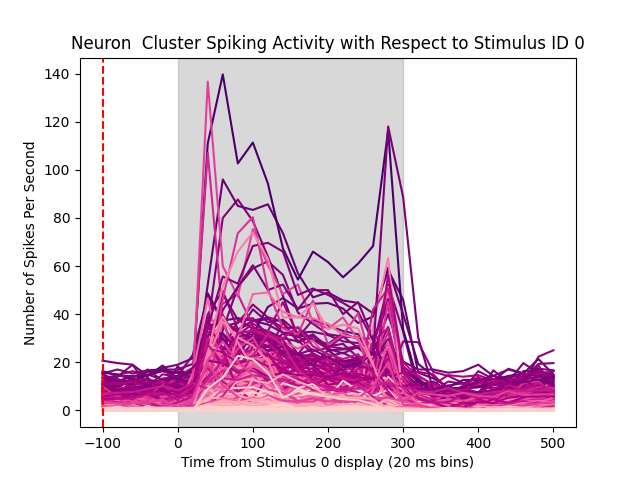

In [ ]:
plot_interactive_graph(prepped_data)

## Navigating the probes:

Simulate the experiment by placing a probe in Pinpoint and playing around with its location. The neurons in the scene will be filtered to just the ones near the length of the probe (presumably the data points you would see if you were to have inserted a real probe there).

To add a probe, press the "Add Probe" button from the right and pick one. The top left option (NP 1.0) is reccommended since it has one shank so it makes filtering easy.
- Use your WASD keys to move the probe around along the brain surface
- Use Q and E to drive it down.
- Use the Ctrl and Shift keys to change the movement step size
- Use the coordinate panel on the right to type in exact coordinates and rotations

Tap the movements keys to move the probe around instead of pressing and holding for best results.